<a href="https://colab.research.google.com/github/martostwo/Recurrent_Neural_Network_TimeSeries_Forecasting/blob/main/RNN_Load_Models_%26_Bagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Models & Bagging Method

#Import & Dark Mode

Modules Installation

In [ ]:
!pip install yfinance
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 15.1 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-

Module import & Dark Mode

In [ ]:
#Module Import:
import pandas as pd;
import numpy as np;
import warnings;
import yfinance as yf;
import ta;
import matplotlib.pyplot as plt;
from matplotlib import cycler;
plt.style.use('seaborn');
warnings.filterwarnings("ignore");

#Dark mode for Graphics:
colors = cycler(
    'color',
    [
    '#669FEE','#66EE91', '#9988DD',
    '#EECC55', '#88BB44', '#FFBBBB'
    ]
);

plt.rc('figure', facecolor = '#313233');
plt.rc('axes', facecolor = "#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor = 'gray');

plt.rc('grid', color='474A4A', linestyle='solid');
plt.rc('xtick', color='gray');
plt.rc('ytick', direction='out', color='gray');
plt.rc('legend', facecolor="#313233", edgecolor="#313233");
plt.rc("text", color="#C9C9C9");
plt.rc('figure', facecolor='#313233');

<ipython-input-2-e0d92d8f87f3>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn');


#Preprocessing & Features

Preprocessing & Feature Engineering Functions (Yahoo Finance)

In [ ]:
def yf_preprocessing(ticker):
  df = yf.download(ticker, start="1990-01-01")
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "date"
  return df

def yf_feature(df):

    #Copiamos el DataFrame para evitar interferencias en los datos:
    df_copy = df.copy()

    #creamos el retorno:
    df_copy["returns"] = df_copy["close"].pct_change(1)

    #price
    df_copy["op"] = df_copy["open"].shift(1)
    df_copy["hi"] = df_copy["high"].shift(1)
    df_copy["lo"] = df_copy["low"].shift(1)
    df_copy["clo"] = df_copy["close"].shift(1)

    #Volume
    df_copy["vol"] = df_copy["volume"].shift(1)

    #Creamos las SMAs:
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    #Creamos la volatilidad:
    df_copy["MSD 15"] = df_copy["returns"].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy["returns"].rolling(60).std().shift(1)

    #creamos VWAP:
    vwap = ta.volume.VolumeWeightedAveragePrice(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        volume=df['volume'],
        window=5  # periodo de tiempo para el cálculo del VWAP
    )
    df_copy["vwap"] = vwap.vwap.shift(1)

    #Creamos el RSI:
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 5, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)

    return df_copy.dropna();

Transform 2D array to 3D

In [ ]:
def X_3d_RNN(X_s, y_s, lag):

    # Verificación simple de longitudes
    if len(X_s) != len(y_s):
        print("Warnings")

    # Creamos la variable X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Creamos la variable y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train

#Load & Run Models

Load & Run Models (Yahoo Finance)

In [ ]:
def run_models(ticker ,models_path):

  #Feature engineering
  global df;
  df = yf_preprocessing(ticker);
  df = yf_feature(df);

  #Percentage train set
  global split, split_val;
  split = int(0.85*len(df));
  split_val = int(0.95*len(df));

  #Train set
  x_train = df[['vwap','rsi','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[:split,:]
  y_train = df[['returns']].iloc[:split,:]

  #Validation set
  x_val = df[['vwap','rsi','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split:split_val,:]
  y_val = df[['returns']].iloc[split:split_val,:]

  #Test set
  x_test = df[['vwap','rsi','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split_val:,:]
  y_test = df[['returns']].iloc[split_val:,:]


  #Standardization
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()

  #Estandarizamos conjunto de entrenamiento
  x_train_sc = sc.fit_transform(x_train)

  #Estandarizamos conjunto de testing
  x_val_sc = sc.transform(x_val)

  #Estandarizamos conjunto de testing
  x_test_sc = sc.transform(x_test)

  lag = 15
  x_train_3d, y_train_3d = X_3d_RNN(x_train_sc, y_train.values, lag)
  x_val_3d, y_val_3d = X_3d_RNN(x_val_sc, y_val.values, lag)
  x_test_3d, y_test_3d = X_3d_RNN(x_test_sc, y_test.values, lag)

  #Create empty dataFrame:
  prediction = pd.DataFrame( index = df.index )
  strategy = pd.DataFrame( index = df.index )
  
  #Cargamos modelos y realizamos predicciones:
  from keras.models import load_model
  from tqdm import tqdm

  for n in tqdm(range(100)):
    
    model_name = f"RNN_{n}"
    RNN = load_model(models_path + f"{model_name}.h5")

    y_pred_train = np.concatenate((np.zeros([lag,1]), RNN.predict(x_train_3d)), axis=0)

    y_pred_val = np.concatenate((np.zeros([lag,1]), RNN.predict(x_val_3d)), axis=0)

    y_pred_test = np.concatenate((np.zeros([lag,1]), RNN.predict(x_test_3d)), axis=0)

    pre = np.concatenate((y_pred_train, y_pred_val, y_pred_test), axis=0)

    prediction[model_name] = pre;
    strategy[model_name] = df["returns"] * np.sign(prediction[model_name].shift(1));
  
  return prediction, strategy;

#Optimum select

Algoritmo de seleción óptima

In [ ]:
#We fixed the problem of stochastic initialization with a criteria that filters the best DNNs
def optimum_select(strategies):

  strat = strategies.dropna()
  all_data = strat
  val_test_data = strat.iloc[split:]
  test_data = strat.iloc[split_val:]

  dnns = all_data.columns

  hopes_all = pd.DataFrame( index = ["hope"] )
  hopes_val_test = pd.DataFrame( index = ["hope"] )
  hopes_test = pd.DataFrame( index = ["hope"] )
  
  for i in dnns:
    hope_all = all_data[i].mean()*100
    hope_val_test = val_test_data[i].mean()*100
    hope_test = test_data[i].mean()*100
    
    hopes_all[i] = hope_all
    hopes_val_test[i] = hope_val_test
    hopes_test[i] = hope_test

  best_all = list(hopes_all.transpose().sort_values(
      by="hope", 
      ascending = False
  ).index[0:4])

  best_val_test = list(hopes_val_test.transpose().sort_values(
      by="hope", 
      ascending = False
  ).index[0:2])

  best_test = list(hopes_test.transpose().sort_values(
      by="hope", 
      ascending = False
  ).index[0:4])

  return list(set(best_all + best_val_test + best_test))

#Algoritmo de selección óptima y mejor combinación

In [ ]:
#We fixed the problem of stochastic initialization with a criteria that filters the best DNNs
import itertools as iter
from itertools import islice

def optimum_select_comb(predictions, strategies):

  strat = strategies.dropna()
  all_data = strat
  val_test_data = strat.iloc[split:]
  test_data = strat.iloc[split_val:]

  dnns = all_data.columns

  hopes_all = pd.DataFrame( index = ["hope"] )
  hopes_val_test = pd.DataFrame( index = ["hope"] )
  hopes_test = pd.DataFrame( index = ["hope"] )
  
  for i in dnns:
    hopes_all[i] = all_data[i].mean()*100
    hopes_val_test[i] = val_test_data[i].mean()*100
    hopes_test[i] = test_data[i].mean()*100
    
  best_all = list(hopes_all.transpose().sort_values(
      by="hope", 
      ascending = False
  ).index[0:6])

  best_val_test = list(hopes_val_test.transpose().sort_values(
      by="hope", 
      ascending = False
  ).index[0:6])

  best_test = list(hopes_test.transpose().sort_values(
      by="hope", 
      ascending = False
  ).index[0:6])

  #Calculamos todas las combinaciones de modelos sin repetición
  best = list(set(best_all + best_val_test + best_test))
  combination = []

  for r in range(3, len(best)+1):
    combination.extend(list(iter.combinations(best, r)))

  #Calculamos la esperanza matemática de retorno diario de cada combinación (bagging)
  best_comb = {}

  for comb in combination:

    #Calculamos decisiones de compra o venta
    best_pre = predictions[list(comb)]
    best_pre["Buy"] = (np.sign(best_pre) == 1).sum(axis=1);
    best_pre["Sell"] = (np.sign(best_pre) == -1).sum(axis=1);

    #Calculamos posición final haciendo Bagging:
    best_pre["position"] = np.nan;

    best_pre.loc[ best_pre["Buy"] > best_pre["Sell"] ,"position"] = 1;
    best_pre.loc[ best_pre["Buy"] == best_pre["Sell"] ,"position"] = 0;
    best_pre.loc[ best_pre["Sell"] > best_pre["Buy"] ,"position"] = -1;

    best_pre["strategy"] = df["returns"] * best_pre["position"].shift(1);

    #Ratio de sortino
    mean = best_pre['strategy'].mean();
    volatility = best_pre['strategy'].loc[best_pre['strategy'] < 0].std();
    sortino = np.sqrt(256)*mean/volatility;

    best_comb[comb] = sortino
  
  # Ordenar el diccionario por mayor esperanza matemática
  best_comb = dict(sorted(best_comb.items(), key=lambda item: item[1], reverse = True))

  return list(islice(best_comb.keys(),50))

#Run Models

Run models

In [ ]:
#df_pre, df_strat = run_models(
#    "/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/EURUSD_Daily_1990.csv",
#    "/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/Models_DNN/"
#);

df_pre, df_strat = run_models(
    "^GSPC",
    "/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/Models/ModelsRNN_^GSPC/"
);

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/100 [00:00<?, ?it/s]

13/13 [==============================] - 0s 7ms/step


  1%|          | 1/100 [00:09<15:21,  9.31s/it]

13/13 [==============================] - 0s 7ms/step


  2%|▏         | 2/100 [00:13<10:39,  6.53s/it]

13/13 [==============================] - 0s 8ms/step


  3%|▎         | 3/100 [00:19<09:54,  6.13s/it]

13/13 [==============================] - 0s 7ms/step


  4%|▍         | 4/100 [00:24<08:46,  5.49s/it]

13/13 [==============================] - 0s 8ms/step


  5%|▌         | 5/100 [00:28<08:01,  5.07s/it]

13/13 [==============================] - 0s 8ms/step


  6%|▌         | 6/100 [00:33<08:13,  5.25s/it]

13/13 [==============================] - 0s 6ms/step


  7%|▋         | 7/100 [00:38<07:39,  4.94s/it]

13/13 [==============================] - 0s 7ms/step


  8%|▊         | 8/100 [00:42<07:17,  4.76s/it]

13/13 [==============================] - 0s 11ms/step


  9%|▉         | 9/100 [00:48<07:37,  5.03s/it]

13/13 [==============================] - 0s 8ms/step


 10%|█         | 10/100 [00:53<07:35,  5.06s/it]

13/13 [==============================] - 0s 10ms/step


 11%|█         | 11/100 [00:58<07:35,  5.11s/it]

13/13 [==============================] - 0s 8ms/step


 12%|█▏        | 12/100 [01:04<07:39,  5.22s/it]

13/13 [==============================] - 0s 8ms/step


 13%|█▎        | 13/100 [01:08<07:14,  5.00s/it]

13/13 [==============================] - 0s 9ms/step


 14%|█▍        | 14/100 [01:13<07:17,  5.08s/it]

13/13 [==============================] - 0s 7ms/step


 15%|█▌        | 15/100 [01:19<07:23,  5.22s/it]

13/13 [==============================] - 0s 7ms/step


 16%|█▌        | 16/100 [01:24<07:05,  5.06s/it]

13/13 [==============================] - 0s 8ms/step


 17%|█▋        | 17/100 [01:32<08:22,  6.05s/it]

13/13 [==============================] - 0s 8ms/step


 18%|█▊        | 18/100 [01:37<07:44,  5.66s/it]

13/13 [==============================] - 0s 11ms/step


 19%|█▉        | 19/100 [01:42<07:37,  5.65s/it]

13/13 [==============================] - 0s 7ms/step


 20%|██        | 20/100 [01:47<07:17,  5.47s/it]

13/13 [==============================] - 0s 8ms/step


 21%|██        | 21/100 [01:52<06:51,  5.21s/it]

13/13 [==============================] - 0s 11ms/step


 22%|██▏       | 22/100 [01:58<06:54,  5.31s/it]

13/13 [==============================] - 0s 7ms/step


 23%|██▎       | 23/100 [02:04<07:07,  5.56s/it]

13/13 [==============================] - 0s 12ms/step


 24%|██▍       | 24/100 [02:09<06:53,  5.44s/it]

13/13 [==============================] - 0s 8ms/step


 25%|██▌       | 25/100 [02:14<06:51,  5.49s/it]

13/13 [==============================] - 0s 8ms/step


 26%|██▌       | 26/100 [02:21<07:05,  5.75s/it]

13/13 [==============================] - 0s 11ms/step


 27%|██▋       | 27/100 [02:26<06:55,  5.69s/it]

13/13 [==============================] - 0s 7ms/step


 28%|██▊       | 28/100 [02:32<06:49,  5.69s/it]

13/13 [==============================] - 0s 11ms/step


 29%|██▉       | 29/100 [02:37<06:38,  5.61s/it]

13/13 [==============================] - 0s 7ms/step


 30%|███       | 30/100 [02:43<06:26,  5.52s/it]

13/13 [==============================] - 0s 7ms/step


 31%|███       | 31/100 [02:48<06:10,  5.37s/it]

13/13 [==============================] - 0s 12ms/step


 32%|███▏      | 32/100 [02:53<06:04,  5.36s/it]

13/13 [==============================] - 0s 7ms/step


 33%|███▎      | 33/100 [02:58<05:58,  5.35s/it]

13/13 [==============================] - 0s 7ms/step


 34%|███▍      | 34/100 [03:04<05:52,  5.34s/it]

13/13 [==============================] - 0s 8ms/step


 35%|███▌      | 35/100 [03:09<05:48,  5.36s/it]

13/13 [==============================] - 0s 7ms/step


 36%|███▌      | 36/100 [03:14<05:35,  5.24s/it]

13/13 [==============================] - 0s 11ms/step


 37%|███▋      | 37/100 [03:20<05:46,  5.50s/it]

13/13 [==============================] - 0s 8ms/step


 38%|███▊      | 38/100 [03:25<05:35,  5.42s/it]

13/13 [==============================] - 0s 7ms/step


 39%|███▉      | 39/100 [03:31<05:33,  5.47s/it]

13/13 [==============================] - 0s 9ms/step


 40%|████      | 40/100 [03:37<05:29,  5.49s/it]

13/13 [==============================] - 0s 7ms/step


 41%|████      | 41/100 [03:41<05:11,  5.28s/it]

13/13 [==============================] - 0s 7ms/step


 42%|████▏     | 42/100 [03:46<05:00,  5.18s/it]

13/13 [==============================] - 0s 8ms/step


 43%|████▎     | 43/100 [03:52<05:09,  5.44s/it]

13/13 [==============================] - 0s 7ms/step


 44%|████▍     | 44/100 [03:58<05:04,  5.45s/it]

13/13 [==============================] - 0s 11ms/step


 45%|████▌     | 45/100 [04:04<05:09,  5.62s/it]

13/13 [==============================] - 0s 7ms/step


 46%|████▌     | 46/100 [04:09<04:57,  5.50s/it]

13/13 [==============================] - 0s 7ms/step


 47%|████▋     | 47/100 [04:15<04:55,  5.58s/it]

13/13 [==============================] - 0s 7ms/step


 48%|████▊     | 48/100 [04:21<05:01,  5.80s/it]

13/13 [==============================] - 0s 8ms/step


 49%|████▉     | 49/100 [04:26<04:48,  5.65s/it]

13/13 [==============================] - 0s 10ms/step


 50%|█████     | 50/100 [04:32<04:35,  5.50s/it]

13/13 [==============================] - 0s 7ms/step


 51%|█████     | 51/100 [04:37<04:32,  5.56s/it]

13/13 [==============================] - 0s 8ms/step


 52%|█████▏    | 52/100 [04:42<04:13,  5.29s/it]

13/13 [==============================] - 0s 10ms/step


 53%|█████▎    | 53/100 [04:47<04:11,  5.35s/it]

13/13 [==============================] - 0s 8ms/step


 54%|█████▍    | 54/100 [04:52<03:59,  5.20s/it]

13/13 [==============================] - 0s 8ms/step


 55%|█████▌    | 55/100 [04:57<03:47,  5.05s/it]

13/13 [==============================] - 0s 7ms/step


 56%|█████▌    | 56/100 [05:03<03:50,  5.23s/it]

13/13 [==============================] - 0s 8ms/step


 57%|█████▋    | 57/100 [05:08<03:44,  5.22s/it]

13/13 [==============================] - 0s 10ms/step


 58%|█████▊    | 58/100 [05:13<03:38,  5.21s/it]

13/13 [==============================] - 0s 8ms/step


 59%|█████▉    | 59/100 [05:19<03:47,  5.55s/it]

13/13 [==============================] - 0s 8ms/step


 60%|██████    | 60/100 [05:24<03:30,  5.26s/it]

13/13 [==============================] - 0s 11ms/step


 61%|██████    | 61/100 [05:30<03:31,  5.41s/it]

13/13 [==============================] - 0s 7ms/step


 62%|██████▏   | 62/100 [05:35<03:28,  5.49s/it]

13/13 [==============================] - 0s 8ms/step


 63%|██████▎   | 63/100 [05:41<03:20,  5.41s/it]

13/13 [==============================] - 0s 7ms/step


 64%|██████▍   | 64/100 [05:46<03:19,  5.55s/it]

13/13 [==============================] - 0s 8ms/step


 65%|██████▌   | 65/100 [05:51<03:01,  5.20s/it]

13/13 [==============================] - 0s 9ms/step


 66%|██████▌   | 66/100 [05:57<03:05,  5.46s/it]

13/13 [==============================] - 0s 8ms/step


 67%|██████▋   | 67/100 [06:03<03:03,  5.55s/it]

13/13 [==============================] - 0s 8ms/step


 68%|██████▊   | 68/100 [06:08<02:54,  5.45s/it]

13/13 [==============================] - 0s 10ms/step


 69%|██████▉   | 69/100 [06:13<02:47,  5.40s/it]

13/13 [==============================] - 0s 8ms/step


 70%|███████   | 70/100 [06:18<02:37,  5.27s/it]

13/13 [==============================] - 0s 8ms/step


 71%|███████   | 71/100 [06:23<02:30,  5.20s/it]

13/13 [==============================] - 0s 8ms/step


 72%|███████▏  | 72/100 [06:30<02:36,  5.57s/it]

13/13 [==============================] - 0s 8ms/step


 73%|███████▎  | 73/100 [06:34<02:24,  5.35s/it]

13/13 [==============================] - 0s 10ms/step


 74%|███████▍  | 74/100 [06:41<02:25,  5.60s/it]

13/13 [==============================] - 0s 8ms/step


 75%|███████▌  | 75/100 [06:46<02:19,  5.57s/it]

13/13 [==============================] - 0s 8ms/step


 76%|███████▌  | 76/100 [06:51<02:06,  5.26s/it]

13/13 [==============================] - 0s 11ms/step


 77%|███████▋  | 77/100 [06:56<02:03,  5.37s/it]

13/13 [==============================] - 0s 9ms/step


 78%|███████▊  | 78/100 [07:01<01:54,  5.20s/it]

13/13 [==============================] - 0s 10ms/step


 79%|███████▉  | 79/100 [07:07<01:56,  5.55s/it]

13/13 [==============================] - 0s 8ms/step


 80%|████████  | 80/100 [07:13<01:50,  5.53s/it]

13/13 [==============================] - 0s 8ms/step


 81%|████████  | 81/100 [07:19<01:48,  5.71s/it]

13/13 [==============================] - 0s 10ms/step


 82%|████████▏ | 82/100 [07:25<01:42,  5.70s/it]

13/13 [==============================] - 0s 7ms/step


 83%|████████▎ | 83/100 [07:30<01:33,  5.49s/it]

13/13 [==============================] - 0s 8ms/step


 84%|████████▍ | 84/100 [07:34<01:22,  5.19s/it]

13/13 [==============================] - 0s 9ms/step


 85%|████████▌ | 85/100 [07:40<01:19,  5.27s/it]

13/13 [==============================] - 0s 8ms/step


 86%|████████▌ | 86/100 [07:46<01:17,  5.53s/it]

13/13 [==============================] - 0s 9ms/step


 87%|████████▋ | 87/100 [07:51<01:08,  5.30s/it]

13/13 [==============================] - 0s 7ms/step


 88%|████████▊ | 88/100 [07:57<01:05,  5.48s/it]

13/13 [==============================] - 0s 8ms/step


 89%|████████▉ | 89/100 [08:01<00:57,  5.21s/it]

13/13 [==============================] - 0s 11ms/step


 90%|█████████ | 90/100 [08:06<00:52,  5.26s/it]

13/13 [==============================] - 0s 8ms/step


 91%|█████████ | 91/100 [08:11<00:45,  5.11s/it]

13/13 [==============================] - 0s 8ms/step


 92%|█████████▏| 92/100 [08:16<00:40,  5.11s/it]

13/13 [==============================] - 0s 8ms/step


 93%|█████████▎| 93/100 [08:23<00:38,  5.54s/it]

13/13 [==============================] - 0s 8ms/step


 94%|█████████▍| 94/100 [08:28<00:31,  5.27s/it]

13/13 [==============================] - 0s 13ms/step


 95%|█████████▌| 95/100 [08:33<00:27,  5.44s/it]

13/13 [==============================] - 0s 8ms/step


 96%|█████████▌| 96/100 [08:39<00:22,  5.51s/it]

13/13 [==============================] - 0s 7ms/step


 97%|█████████▋| 97/100 [08:44<00:16,  5.41s/it]

13/13 [==============================] - 0s 11ms/step


 98%|█████████▊| 98/100 [08:50<00:11,  5.53s/it]

13/13 [==============================] - 0s 8ms/step


 99%|█████████▉| 99/100 [08:55<00:05,  5.43s/it]

13/13 [==============================] - 0s 8ms/step


100%|██████████| 100/100 [09:00<00:00,  5.40s/it]


In [ ]:
optimum = optimum_select_comb(df_pre, df_strat)
optimum[0]

('RNN_40', 'RNN_12', 'RNN_16', 'RNN_43', 'RNN_17', 'RNN_1', 'RNN_81')

#Backtesting

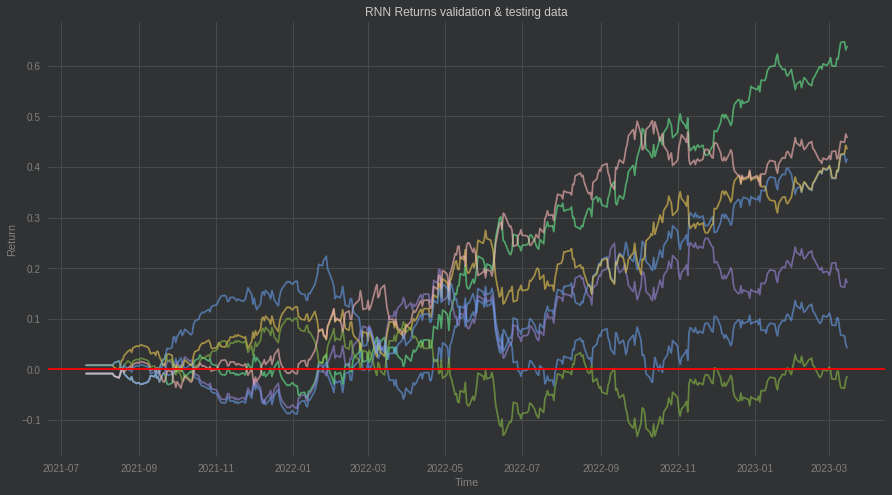

              RNN_40    RNN_12    RNN_16    RNN_43    RNN_17     RNN_1  \
date                                                                     
2021-07-21 -0.008242 -0.008242 -0.008242  0.008242  0.008242 -0.008242   
2021-07-22  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-07-23  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-07-26  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-07-27 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000   
...              ...       ...       ...       ...       ...       ...   
2023-03-09  0.018459  0.018459 -0.018459  0.018459 -0.018459  0.018459   
2023-03-10  0.014478  0.014478 -0.014478  0.014478 -0.014478  0.014478   
2023-03-13  0.001510  0.001510 -0.001510  0.001510 -0.001510 -0.001510   
2023-03-14 -0.016477 -0.016477  0.016477  0.016477  0.016477  0.016477   
2023-03-15  0.006981  0.006981 -0.006981 -0.006981  0.006981 -0.006981   

              RNN_81  
date          

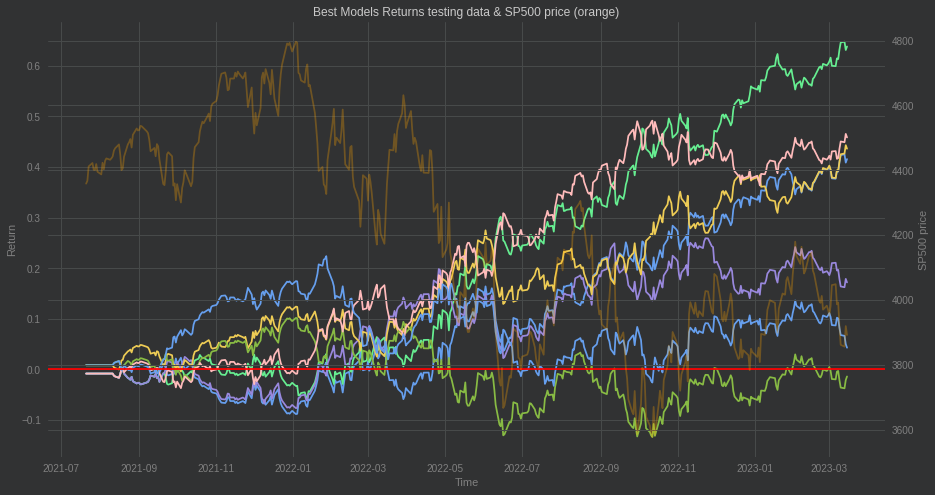

In [ ]:
#Selección de los modelos con las mejores estrategias:
best_models = ['RNN_40', 'RNN_12', 'RNN_16', 'RNN_43', 'RNN_17', 'RNN_1', 'RNN_81']
best_strategies = df_strat[best_models].iloc[split_val:]

#Graph val-test
plt.figure(figsize=(15,8))
plt.plot(best_strategies.cumsum(axis=0), alpha=0.6)
plt.axhline(0, color="red")
plt.title("RNN Returns validation & testing data")
plt.ylabel("Return")
plt.xlabel("Time")
plt.show()
print(best_strategies)

#Graph test
plt.figure(figsize=(15,8))
ax1 = plt.subplot(111)
ax1.plot(df_strat[best_models].iloc[split_val:].cumsum(axis=0))
plt.ylabel("Return")
plt.xlabel("Time")
plt.axhline(0, color="red")
ax2 = ax1.twinx();
ax2.plot(df[['close']].iloc[split_val:], color = "orange", alpha = 0.3)
plt.ylabel("SP500 price")
plt.title("Best Models Returns testing data & SP500 price (orange)")
plt.show()

In [ ]:
#Calculamos decisiones de compra o venta
best_pre = df_pre[best_models].iloc[:];
best_pre["Buy"] = (np.sign(best_pre) == 1).sum(axis=1);
best_pre["Sell"] = (np.sign(best_pre) == -1).sum(axis=1);
best_pre

,RNN_40,RNN_12,RNN_16,RNN_43,RNN_17,RNN_1,RNN_81,Buy,Sell
date,,,,,,,,,
1990-03-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1990-03-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1990-04-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1990-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1990-04-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...
2023-03-09,-0.000568,-0.000220,0.001044,-0.000755,0.000965,-0.000135,0.000090,3,4
2023-03-10,-0.000490,-0.000014,0.000829,-0.000744,0.000507,0.000191,0.000116,4,3
2023-03-13,-0.000336,-0.000505,0.001077,0.000072,0.000025,0.000440,-0.000177,4,3


In [ ]:
#Calculamos posición final haciendo Bagging:
best_pre["position"] = np.nan;

best_pre.loc[ best_pre["Buy"] > best_pre["Sell"] ,"position"] = 1;
best_pre.loc[ best_pre["Buy"] == best_pre["Sell"] ,"position"] = 0;
best_pre.loc[ best_pre["Sell"] > best_pre["Buy"] ,"position"] = -1;

#Calculamos y representamos retornos:
best_pre["strategy"] = df["returns"] * best_pre["position"].shift(1);

best_pre

,RNN_40,RNN_12,RNN_16,RNN_43,RNN_17,RNN_1,RNN_81,Buy,Sell,position,strategy
date,,,,,,,,,,,
1990-03-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.0,NaN
1990-03-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.0,-0.000000
1990-04-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.0,-0.000000
1990-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0.000000
1990-04-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.0,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,-0.000568,-0.000220,0.001044,-0.000755,0.000965,-0.000135,0.000090,3,4,-1.0,0.018459
2023-03-10,-0.000490,-0.000014,0.000829,-0.000744,0.000507,0.000191,0.000116,4,3,1.0,0.014478
2023-03-13,-0.000336,-0.000505,0.001077,0.000072,0.000025,0.000440,-0.000177,4,3,1.0,-0.001510


#Búsqueda del mejor SL en función del ratio de Sharpe

In [ ]:
def find_best_sl(sl):
  
  sl = sl/100
  pf = pd.concat((df["low_returns"], best_pre["strategy"]), axis = 1).dropna()
  pf.columns = ["low", "Return"]
  pf["Return"] = np.where(pf["low"].values < -sl, -sl, pf["Return"].values)
  pf["Return"] = np.where(pf["Return"].values < -sl, -sl, pf["Return"].values)

  return np.sqrt(252)*pf["Return"].mean()/pf["Return"].std()

df_sl = pd.DataFrame(
    [find_best_sl(sl) for sl in np.linspace(1,10,50)],
    index = np.linspace(1,1.5,50),
    columns = ["Sharpe"]
)

best_sl = df_sl["Sharpe"].idxmax()
print(f"Best SL : {best_sl}")

sl = best_sl/100
pf = pd.concat((df["low_returns"], best_pre["strategy"]), axis = 1).dropna()
pf.columns = ["low", "Return"]
pf["Return"] = np.where(pf["low"].values < -sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values < -sl, -sl, pf["Return"].values)
pf["Return"].cumsum().plot();
plt.ylabel("Cum return");
plt.title("Cumulative return")
plt.show()

KeyError: ignored

# Metrics

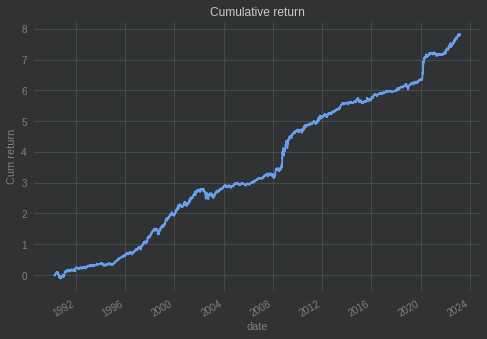

Esperanza matemática del retorno diario del modelo Híbrido: 0.0943 % 

Pérdida media cuando pierde: -0.74 %
Ganancia media cuando gana: 0.8 % 

Probabilidad de acierto: 54.64 %
Probabilidad de fallo: 45.36 %

Rentabilidad Final: 782.87 %
Ratio riesgo-beneficio: 1.07

Máxima pérdida en un día: -9.29 % => 2020-03-13 00:00:00
Máxima ganancia en un día: 11.98 % => 2020-03-16 00:00:00 

Nº máximo de días en negativo: 8
Pérdida media acumulada en 8 días: -5.93 % 


In [ ]:
#Graph cum return
best_pre["strategy"].cumsum().plot();
plt.ylabel("Cum return");
plt.title("Cumulative return")
plt.show()

#Esperanza matemática:
print(f"Esperanza matemática del retorno diario del modelo Híbrido: {round(best_pre['strategy'].mean()*100, 4)} % \n");

loss = best_pre["strategy"].loc[ best_pre['strategy'] < 0 ].mean()
profit = best_pre["strategy"].loc[ best_pre['strategy'] > 0 ].mean()
prob_succ = len(best_pre.loc[ best_pre['strategy'] >= 0 ])/len(best_pre)
final_return = best_pre["strategy"].cumsum().iloc[-1]
max_loss = best_pre["strategy"].min()*100
max_profit = best_pre["strategy"].max()*100
date_max_loss = best_pre["strategy"].idxmin()
date_max_profit = best_pre["strategy"].idxmax()

#Calculamos el nº max de días seguidos en negativo:

# Crear una columna que indique si el rendimiento es negativo
best_pre['Negativo'] = best_pre['strategy'] < 0

# Crear una columna que indique los grupos de días seguidos con rendimiento negativo
best_pre['Grupo'] = (best_pre['Negativo'] != best_pre['Negativo'].shift()).cumsum()

# Obtener el número de días seguidos con rendimiento negativo para cada grupo
max_loss_days = best_pre[best_pre['Negativo']]['Grupo'].value_counts().max()

print(f"Pérdida media cuando pierde: {round(loss*100,2)} %")
print(f"Ganancia media cuando gana: {round(profit*100,2)} % \n")

print(f"Probabilidad de acierto: {round(prob_succ*100,2)} %")
print(f"Probabilidad de fallo: {round(100-prob_succ*100,2)} %\n")

print(f"Rentabilidad Final: {round(final_return*100,2)} %")
print(f"Ratio riesgo-beneficio: {round(profit/abs(loss),2)}\n")

print(f"Máxima pérdida en un día: {round(max_loss,2)} % => {date_max_loss}")
print(f"Máxima ganancia en un día: {round(max_profit,2)} % => {date_max_profit} \n")

print(f"Nº máximo de días en negativo: {max_loss_days}")
print(f"Pérdida media acumulada en {max_loss_days} días: {round(max_loss_days*loss*100, 2)} % ")

#Backtesting Vectorizado

Ratio de Sortino anualizado

Mide el valor esperado de retorno por unidad de riesgo (volatilidad de las pérdidas).

<br>
<p align="center">
$Sortino = \frac{\mu }{\sigma_{down}}$
<p> <br>


*   Sortino < 0 => No rentable, beneficio negativo.
*   0 < Sortino < 1 => Rentable pero el riesgo es mayor que el beneficio
*   Sortino > 1 => Muy rentable, el beneficio es mayor que el riesgo.



In [ ]:
#Sortino's variables
mean = best_pre['strategy'].mean();
volatility = best_pre['strategy'].loc[best_pre['strategy'] < 0].std();

sortino = np.sqrt(256)*mean/volatility;
print(f"Ratio de Sortino: {sortino}")

Ratio de Sortino: 1.8713698051101024


BETA

El Beta se utiliza para medir la sensibilidad de un activo financiero (como una acción) con respecto a los movimientos del mercado en su conjunto. Es decir, mide la volatilidad del activo en relación con el mercado en general.

<br>

<p align="center">
$Beta = \frac{Cov(r_{M},r_{PF}) }{Var(r_{M})}$
<p> <br>

Si el Beta de un activo es mayor que 1, significa que el activo es más volátil que el mercado. Por ejemplo, si el mercado sube un 1%, un activo con un Beta de 1.5 debería subir un 1.5%. Si el Beta de un activo es menor que 1, significa que el activo es menos volátil que el mercado. Por ejemplo, si el mercado sube un 1%, un activo con un Beta de 0.5 debería subir solo un 0.5%.

In [ ]:
import yfinance as yf;

#Extraemos data del SP500. Retornos diarios:
SP = yf.download("^GSPC")["Close"].pct_change(1);
SP.name = "sp500";

#Concatenamos los retornos de nuestra estrategia con los del SP500
#para calcular la covarianza:
val = pd.concat((best_pre["strategy"], SP), axis = 1).dropna();
val

[*********************100%***********************]  1 of 1 completed


,strategy,sp500
1990-03-30,-0.000000,-0.002494
1990-04-02,-0.000000,-0.003648
1990-04-03,0.000000,0.014585
1990-04-04,-0.000000,-0.007421
1990-04-05,-0.000000,-0.001055
...,...,...
2023-03-09,0.018459,-0.018459
2023-03-10,0.014478,-0.014478
2023-03-13,-0.001510,-0.001510
2023-03-14,0.016477,0.016477


In [ ]:
#Matriz de covarianza
cov_var_matrix = np.cov(val.values, rowvar=False);
cov_var_matrix

array([[1.32084753e-04, 6.15836953e-05],
       [6.15836953e-05, 1.33113911e-04]])

In [ ]:
#Beta
cov = cov_var_matrix[0][1];
var_market = cov_var_matrix[1][1];

beta = abs(cov/var_market);
print(f"Beta de nuestra estrategia: {beta}");

Beta de nuestra estrategia: 0.46263906632116764


ALPHA

El Alpha mide la rentabilidad adicional de un activo financiero en relación con su riesgo sistemático (medido por su coeficiente Beta) y con el mercado en general. Es decir, el Alpha mide cuánto mejor o peor ha funcionado un activo en comparación con su rendimiento esperado dada su exposición al mercado.

<br>

<p align="center">
$Alpha = r_{PF} - \beta*(r_{PF} - r_{f}) - r_{f}$
<p> <br>


Un Alpha positivo indica que el activo ha superado su rendimiento esperado, mientras que un Alpha negativo indica que el activo ha rendido peor de lo esperado. En otras palabras, un Alpha positivo indica que el activo ha proporcionado un rendimiento excedente en relación con el riesgo asumido, mientras que un Alpha negativo indica que el activo ha proporcionado un rendimiento deficiente en relación con el riesgo asumido.

In [ ]:
#Calculamos alpha anualizado:
mean = best_pre['strategy'].mean();
alpha = (252*mean*(1-beta))*100;
print(f"Alpha: {alpha} %");

Alpha: 12.679214305328346 %


DRAWDOWN

El drawdown mide la reducción en el valor de un activo o cartera desde su punto más alto hasta su punto más bajo.

<br>

<p align="center">
$Drawdown = -\frac{𝕍max - 𝕍min}{𝕍max}$
<p> <br>


Por ejemplo, si el valor máximo histórico de una cartera de inversión fue de usd 100,000 y luego cayó a usd 80,000 antes de volver a subir, entonces el drawdown de esa cartera fue del 20% (es decir, la reducción fue de usd 20,000, o el 20% del valor máximo).

In [ ]:
def drawdown_function(serie):

  # Calculamos la suma de los rendimientos
  cum = serie.dropna().cumsum() + 1

  # Calculamos el máximo de la suma en el período (máximo acumulado) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # Calculamos el drawdown
  drawdown = cum/running_max - 1
  return drawdown

In [ ]:
# Calculamos el drawdown
drawdown = drawdown_function(best_pre["strategy"])
drawdown

date
1990-03-30    0.000000
1990-04-02    0.000000
1990-04-03    0.000000
1990-04-04    0.000000
1990-04-05    0.000000
                ...   
2023-03-09    0.000000
2023-03-10    0.000000
2023-03-13   -0.000172
2023-03-14    0.000000
2023-03-15   -0.000795
Name: strategy, Length: 8303, dtype: float64

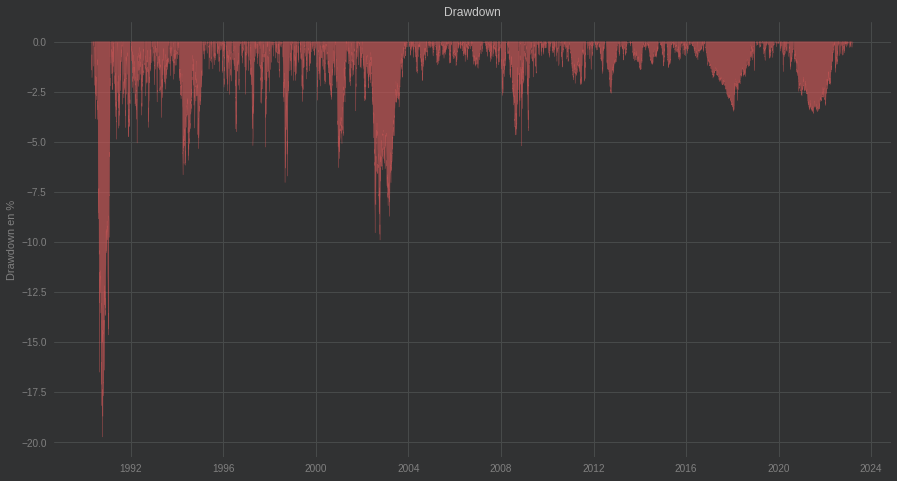

Max drawdown: 19.7 %


In [ ]:
# Adaptar el tamaño de la figura
plt.figure(figsize=(15,8))

# Representar el drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# Añadimos el título
plt.title("Drawdown")

# Etiqueta del eje de la y
plt.ylabel("Drawdown en %")

plt.show()

# Cálculo del drawdown máximo
max_drawdown = -np.min(drawdown)*100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

##Función de Backtesting

In [ ]:
def BackTest(serie, yahoo_ticker, annualiazed_scalar=252):

  # Importar el benchmark
  import yfinance as yf
  close_price = yf.download(yahoo_ticker)["Close"]
  market = close_price.pct_change(1)
  
  # Cambiar el nombre
  market.name = "Market"

  # Concatenar los retornos y el mercado
  val = pd.concat((serie,market), axis=1).dropna()
  # Calcular el drawdown
  drawdown = drawdown_function(serie)*100
  
  # Calcular el max drawdown
  max_drawdown = -np.min(drawdown)

  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # Market cumsum chart
  cum.plot(val["Market"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Model", "Market"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown en %", size=11)

  # Plot the graph
  plt.show()
  
  # Calcular el índice sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Calcular el índice  beta
  beta = abs(np.cov(val[["strategy", "Market"]].values,rowvar=False)[0][1] / np.var(val["Market"].values))

  # Calcular el índice  alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Imprimir los estadísticos
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

    #Graph
  plt.figure(figsize=(15,8))

  ax1 = plt.subplot(111)
  ax1.plot(serie.cumsum(axis = 0)*100)

  plt.ylabel("Return")
  plt.xlabel("Time")

  plt.axhline(0, color="red")

  ax2 = ax1.twinx();
  ax2.plot(df[['close']].iloc[split_val:], color = "orange", alpha = 0.3)

  plt.ylabel(f"{yahoo_ticker} price")

  plt.title(f"Model Returns testing data & {yahoo_ticker} price (orange)")
  plt.show()

#Final Backtesting

[*********************100%***********************]  1 of 1 completed


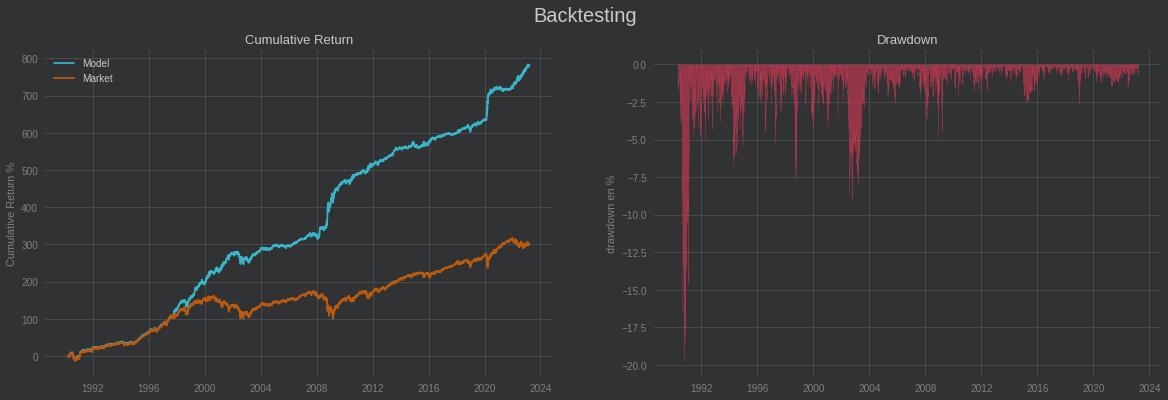

Sortino: 1.886
Beta: 0.487
Alpha: 12.192 %
MaxDrawdown: 19.739 %


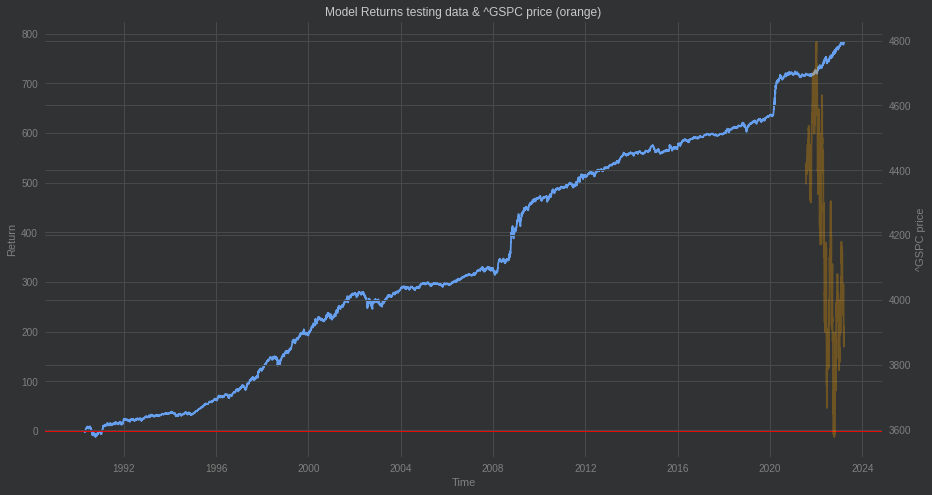

In [ ]:
BackTest(best_pre["strategy"], "^GSPC")